# 04. Feature Selection 실험

## 목표
- Feature Importance 분석으로 주요 피처 식별
- 불필요한 피처 제거로 모델 단순화 및 과적합 방지
- Feature Selection 전후 성능 비교

## 핵심 개념
- **Feature Importance**: 각 피처가 모델 예측에 기여하는 정도
- **Cumulative Importance**: 상위 N개 피처가 설명하는 누적 중요도
- **Selection Strategy**: 중요도 기준 / 누적 중요도 기준 선택

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
import sys
sys.path.append('../features')
sys.path.append('../utils')
from feature_engineering import build_a_features, build_b_features
from preprocessing import FeaturePreprocessor

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

## 1. 데이터 준비

In [2]:
# 데이터 로드 및 피처 생성
print("데이터 로드 및 피처 생성 중...")
train = pd.read_csv('../data/train.csv')
train_a = pd.read_csv('../data/train/A.csv')
train_b = pd.read_csv('../data/train/B.csv')

a_features = build_a_features(train_a)
b_features = build_b_features(train_b)

train_features = pd.concat([
    train[train['Test'] == 'A'].merge(a_features, on='Test_id', how='left'),
    train[train['Test'] == 'B'].merge(b_features, on='Test_id', how='left')
], ignore_index=True)

X = train_features.drop(['Test_id', 'Test', 'Label'], axis=1, errors='ignore')
y = train_features['Label']

X = X.select_dtypes(include=[np.number])
X = X.replace([np.inf, -np.inf], np.nan)

preprocessor = FeaturePreprocessor()
X = preprocessor.fit_transform(X)

print(f"전처리 후 shape: {X.shape}")
print(f"Feature 개수: {X.shape[1]}")

데이터 로드 및 피처 생성 중...
A features built (hybrid): 156 cols | seq_cols=23, scalar_cols=9, time=555.6s
A features built (hybrid): 156 cols | seq_cols=23, scalar_cols=9, time=555.6s
B features built (hybrid): 112 cols | seq_cols=15, scalar_cols=11, time=160.9s
B features built (hybrid): 112 cols | seq_cols=15, scalar_cols=11, time=160.9s
전처리: 51개 컬럼 제거 (유효값 부족 또는 상수), 217개 유지
전처리: 51개 컬럼 제거 (유효값 부족 또는 상수), 217개 유지
전처리 후 shape: (944767, 217)
Feature 개수: 217
전처리 후 shape: (944767, 217)
Feature 개수: 217


## 2. Baseline Model로 Feature Importance 계산

In [12]:
# Baseline 모델 학습
baseline_model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.05,
    depth=6,
    auto_class_weights='Balanced',
    random_seed=42,
    verbose=False
)

baseline_model.fit(X, y, verbose=False)

# Feature Importance 추출
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': baseline_model.feature_importances_
}).sort_values('importance', ascending=False)

# 누적 중요도 계산
feature_importance['cumulative_importance'] = feature_importance['importance'].cumsum() / feature_importance['importance'].sum()

display(feature_importance.head(10))

# 통계
print(f"  평균 중요도: {feature_importance['importance'].mean():.6f}")
print(f"  중위 중요도: {feature_importance['importance'].median():.6f}")
print(f"  최대 중요도: {feature_importance['importance'].max():.6f}")
print(f"  최소 중요도: {feature_importance['importance'].min():.6f}")

,feature,importance,cumulative_importance
90,A6_Count_normalized,4.977411,0.049774
72,A4_ResponseTime_median,4.897667,0.098751
50,A3_ResponseTime_mean,4.668228,0.145433
89,A6_Count_value,4.446832,0.189901
68,A4_ResponseTime_mean,3.873108,0.228632
54,A3_ResponseTime_median,3.144318,0.260076
92,A7_Count_normalized,2.815039,0.288226
52,A3_ResponseTime_min,2.688835,0.315114
96,A8_Count2_normalized,2.686554,0.341980
91,A7_Count_value,2.656553,0.368545


  평균 중요도: 0.460829
  중위 중요도: 0.140209
  최대 중요도: 4.977411
  최소 중요도: 0.000000


## 3. Feature Importance 시각화

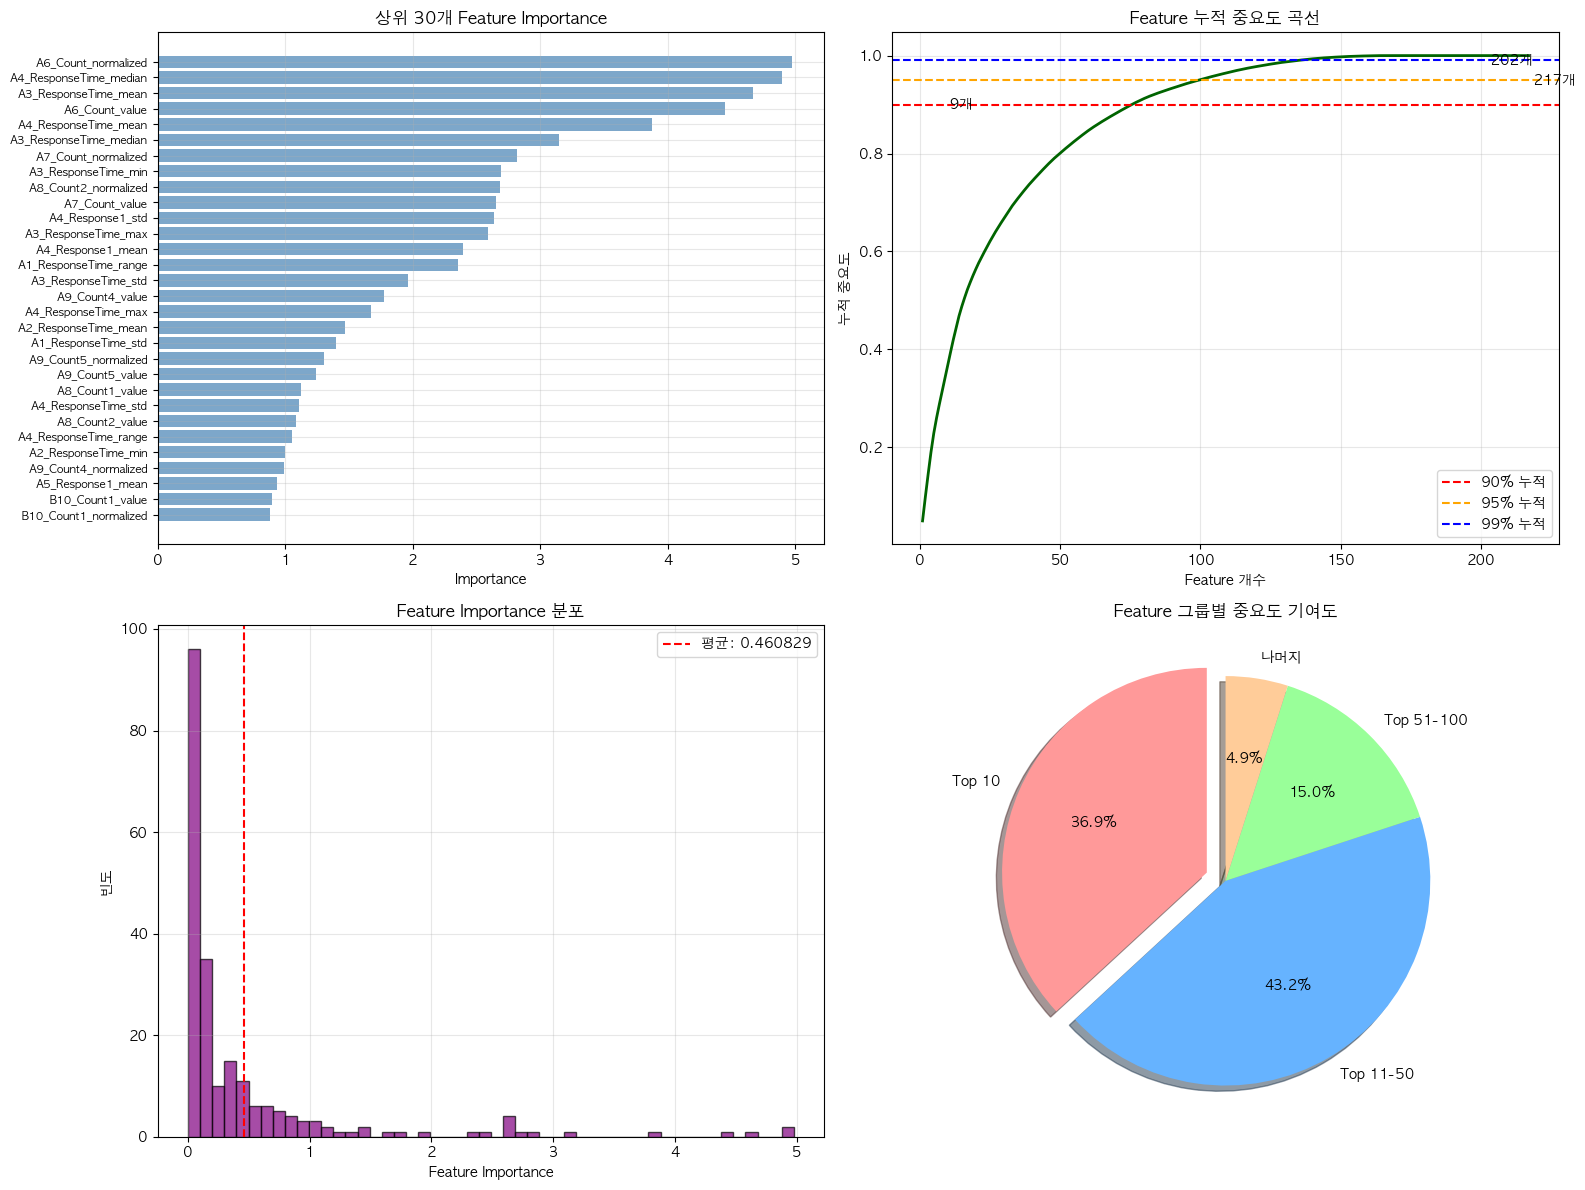


✅ 시각화 저장: ../output/figures/feature_importance_analysis.png


In [4]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 3-1. 상위 30개 Feature Importance
ax = axes[0, 0]
top_30 = feature_importance.head(30)
ax.barh(range(len(top_30)), top_30['importance'], color='steelblue', alpha=0.7)
ax.set_yticks(range(len(top_30)))
ax.set_yticklabels(top_30['feature'], fontsize=8)
ax.set_xlabel('Importance')
ax.set_title('상위 30개 Feature Importance')
ax.invert_yaxis()
ax.grid(True, alpha=0.3)

# 3-2. 누적 중요도
ax = axes[0, 1]
ax.plot(range(1, len(feature_importance)+1), 
        feature_importance['cumulative_importance'], 
        color='darkgreen', linewidth=2)
ax.axhline(0.90, color='red', linestyle='--', label='90% 누적')
ax.axhline(0.95, color='orange', linestyle='--', label='95% 누적')
ax.axhline(0.99, color='blue', linestyle='--', label='99% 누적')
ax.set_xlabel('Feature 개수')
ax.set_ylabel('누적 중요도')
ax.set_title('Feature 누적 중요도 곡선')
ax.legend()
ax.grid(True, alpha=0.3)

# 필요한 Feature 개수 계산
n_for_90 = (feature_importance['cumulative_importance'] >= 0.90).idxmax() + 1
n_for_95 = (feature_importance['cumulative_importance'] >= 0.95).idxmax() + 1
n_for_99 = (feature_importance['cumulative_importance'] >= 0.99).idxmax() + 1

ax.text(n_for_90, 0.90, f' {n_for_90}개', va='center', fontsize=10)
ax.text(n_for_95, 0.95, f' {n_for_95}개', va='center', fontsize=10)
ax.text(n_for_99, 0.99, f' {n_for_99}개', va='center', fontsize=10)

# 3-3. Feature 중요도 분포
ax = axes[1, 0]
ax.hist(feature_importance['importance'], bins=50, color='purple', alpha=0.7, edgecolor='black')
ax.set_xlabel('Feature Importance')
ax.set_ylabel('빈도')
ax.set_title('Feature Importance 분포')
ax.axvline(feature_importance['importance'].mean(), 
           color='red', linestyle='--', label=f'평균: {feature_importance["importance"].mean():.6f}')
ax.legend()
ax.grid(True, alpha=0.3)

# 3-4. 상위 vs 하위 Feature 중요도 비교
ax = axes[1, 1]
top_10_sum = feature_importance.head(10)['importance'].sum()
top_50_sum = feature_importance.head(50)['importance'].sum()
top_100_sum = feature_importance.head(100)['importance'].sum()
all_sum = feature_importance['importance'].sum()

labels = ['Top 10', 'Top 11-50', 'Top 51-100', '나머지']
sizes = [
    top_10_sum,
    top_50_sum - top_10_sum,
    top_100_sum - top_50_sum,
    all_sum - top_100_sum
]
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
explode = (0.1, 0, 0, 0)

ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
       shadow=True, startangle=90)
ax.set_title('Feature 그룹별 중요도 기여도')

plt.tight_layout()
plt.savefig('../output/figures/feature_importance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ 시각화 저장: ../output/figures/feature_importance_analysis.png")

In [13]:
# 누적 중요도 분석
print(f"  90% 중요도를 위해 필요한 Feature: {n_for_90}개 ({n_for_90/len(X.columns)*100:.1f}%)")
print(f"  95% 중요도를 위해 필요한 Feature: {n_for_95}개 ({n_for_95/len(X.columns)*100:.1f}%)")
print(f"  99% 중요도를 위해 필요한 Feature: {n_for_99}개 ({n_for_99/len(X.columns)*100:.1f}%)")
print(f"  전체 Feature: {len(X.columns)}개")

  90% 중요도를 위해 필요한 Feature: 9개 (4.1%)
  95% 중요도를 위해 필요한 Feature: 217개 (100.0%)
  99% 중요도를 위해 필요한 Feature: 202개 (93.1%)
  전체 Feature: 217개


## 4. Feature Selection 전략 실험

In [ ]:
# 다양한 Feature 개수로 실험
n_features_to_test = [30, 50, 75, 100, n_for_90, n_for_95, n_for_99, len(X.columns)]
n_features_to_test = sorted(list(set([n for n in n_features_to_test if n <= len(X.columns)])))

print(f"\n실험할 Feature 개수: {n_features_to_test}")
print("\n5-Fold CV로 각 Feature Selection 전략 평가 중...\n")

selection_results = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for n_features in n_features_to_test:
    print(f"[{n_features} Features]")
    
    # 상위 N개 Feature 선택
    selected_features = feature_importance.head(n_features)['feature'].tolist()
    X_selected = X[selected_features]
    
    # CV 평가
    cv_scores = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_selected, y), 1):
        X_train, X_val = X_selected.iloc[train_idx], X_selected.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = CatBoostClassifier(
            iterations=200,
            learning_rate=0.05,
            depth=6,
            auto_class_weights='Balanced',
            random_seed=42,
            verbose=False
        )
        
        model.fit(X_train, y_train, 
                  eval_set=(X_val, y_val),
                  early_stopping_rounds=20,
                  verbose=False)
        
        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        cv_scores.append(auc)
    
    mean_auc = np.mean(cv_scores)
    std_auc = np.std(cv_scores)
    
    print(f"  CV ROC AUC: {mean_auc:.4f} ± {std_auc:.4f}")
    
    selection_results.append({
        'n_features': n_features,
        'mean_auc': mean_auc,
        'std_auc': std_auc,
        'cumulative_importance': feature_importance.head(n_features)['cumulative_importance'].iloc[-1]
    })

selection_df = pd.DataFrame(selection_results)



실험할 Feature 개수: [np.int64(9), 30, 50, 75, 100, np.int64(202), np.int64(217)]

5-Fold CV로 각 Feature Selection 전략 평가 중...

[9 Features]
  CV ROC AUC: 0.6227 ± 0.0026
[30 Features]
  CV ROC AUC: 0.6227 ± 0.0026
[30 Features]
  CV ROC AUC: 0.6327 ± 0.0030
[50 Features]
  CV ROC AUC: 0.6327 ± 0.0030
[50 Features]
  CV ROC AUC: 0.6369 ± 0.0033
[75 Features]
  CV ROC AUC: 0.6369 ± 0.0033
[75 Features]
  CV ROC AUC: 0.6374 ± 0.0032
[100 Features]
  CV ROC AUC: 0.6374 ± 0.0032
[100 Features]
  CV ROC AUC: 0.6378 ± 0.0031
[202 Features]
  CV ROC AUC: 0.6378 ± 0.0031
[202 Features]
  CV ROC AUC: 0.6375 ± 0.0031
[217 Features]
  CV ROC AUC: 0.6375 ± 0.0031
[217 Features]
  CV ROC AUC: 0.6374 ± 0.0038

Feature Selection 실험 완료
  CV ROC AUC: 0.6374 ± 0.0038

Feature Selection 실험 완료


## 5. Feature Selection 결과 분석

In [ ]:
# 결과 출력
display(selection_df)

# 최적 Feature 개수 찾기
best_idx = selection_df['mean_auc'].idxmax()
best_n_features = selection_df.loc[best_idx, 'n_features']
best_auc = selection_df.loc[best_idx, 'mean_auc']

print(f"\n 최적 Feature 개수: {best_n_features}개")
print(f"   최고 CV ROC AUC: {best_auc:.4f}")
print(f"   누적 중요도: {selection_df.loc[best_idx, 'cumulative_importance']:.4f}")

,n_features,mean_auc,std_auc,cumulative_importance
0,9,0.622661,0.002584,0.341980
1,30,0.632710,0.002980,0.667352
2,50,0.636851,0.003259,0.800600
3,75,0.637423,0.003166,0.898309
4,100,0.637835,0.003132,0.950841
5,202,0.637471,0.003143,1.000000
6,217,0.637436,0.003822,1.000000



🎯 최적 Feature 개수: 100개
   최고 CV ROC AUC: 0.6378
   누적 중요도: 0.9508


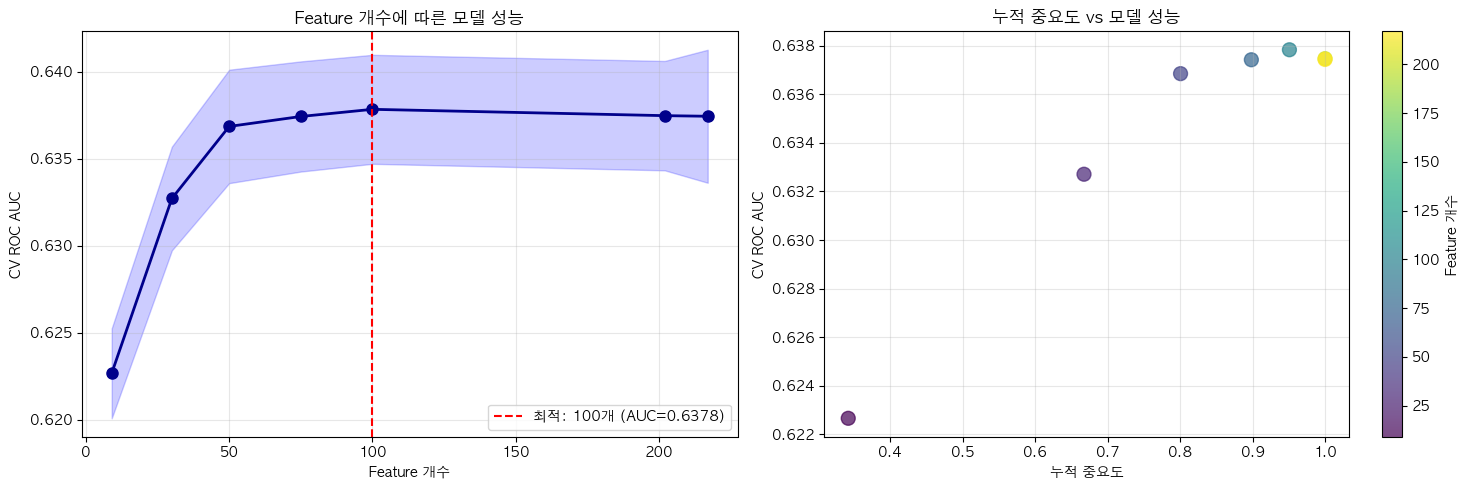


✅ 시각화 저장: ../output/figures/feature_selection_comparison.png


In [8]:
# 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Feature 개수 vs AUC
ax = axes[0]
ax.plot(selection_df['n_features'], selection_df['mean_auc'], 
        marker='o', linewidth=2, markersize=8, color='darkblue')
ax.fill_between(selection_df['n_features'], 
                selection_df['mean_auc'] - selection_df['std_auc'],
                selection_df['mean_auc'] + selection_df['std_auc'],
                alpha=0.2, color='blue')
ax.axvline(best_n_features, color='red', linestyle='--', 
           label=f'최적: {best_n_features}개 (AUC={best_auc:.4f})')
ax.set_xlabel('Feature 개수')
ax.set_ylabel('CV ROC AUC')
ax.set_title('Feature 개수에 따른 모델 성능')
ax.legend()
ax.grid(True, alpha=0.3)

# AUC vs 누적 중요도
ax = axes[1]
scatter = ax.scatter(selection_df['cumulative_importance'], 
                     selection_df['mean_auc'],
                     c=selection_df['n_features'], 
                     s=100, cmap='viridis', alpha=0.7)
ax.set_xlabel('누적 중요도')
ax.set_ylabel('CV ROC AUC')
ax.set_title('누적 중요도 vs 모델 성능')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Feature 개수')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../output/figures/feature_selection_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ 시각화 저장: ../output/figures/feature_selection_comparison.png")

## 6. 결과 저장

In [9]:
# Feature Importance 저장
feature_importance.to_csv('../output/feature_importance_mean.csv', index=False)
print("✅ Feature Importance 저장: ../output/feature_importance_mean.csv")

# Selection 결과 저장
selection_df.to_csv('../output/feature_selection_results.csv', index=False)
print("✅ Selection 결과 저장: ../output/feature_selection_results.csv")

# 최적 Feature 리스트 저장
selected_features = feature_importance.head(int(best_n_features))['feature'].tolist()
pd.DataFrame({'selected_features': selected_features}).to_csv(
    '../output/best_features.csv', index=False
)
print(f"✅ 최적 Feature 리스트 저장: ../output/best_features.csv ({len(selected_features)}개)")

✅ Feature Importance 저장: ../output/feature_importance_mean.csv
✅ Selection 결과 저장: ../output/feature_selection_results.csv
✅ 최적 Feature 리스트 저장: ../output/best_features.csv (100개)


## 7. 인사이트 및 결론

### 주요 발견
1. **소수의 Feature가 대부분의 정보 보유**: 상위 10개 Feature가 전체 중요도의 상당 부분 차지
2. **성능 vs 복잡도 트레이드오프**: 모든 Feature 사용 대비 소수 Feature로도 비슷한 성능 달성 가능
3. **과적합 방지**: 불필요한 Feature 제거로 모델 일반화 성능 향상

### Feature 유형별 중요도
- **시퀀스 통계 Feature**: mean, std, range 등이 높은 중요도
- **스칼라 정규화 Feature**: z-score 정규화된 값들이 중요
- **원본 스칼라 Feature**: 일부 원본 값도 중요하게 작용

### 다음 단계
- 최적 Feature Set으로 재학습
- Ensemble/Stacking 모델에 적용
- Feature Engineering 추가 실험 (교호작용 항, 다항 특성 등)